In [1]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from mvpc.mvpc_pipeline import MVPC

from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

from data.synthetic_data_generation.missingness_synthetic import (
    create_mar_ind, create_mnar_ind,
    generate_missing_values
)

mvpc_vars = [
    "Sodium", "Potassium", "Chloride", "Creatinine", "Urea Nitrogen",
    "Hematocrit", "Hemoglobin", "WBC", "Platelet Count", "Glucose",
    "anchor_age", "length_of_stay_hours",
]

df = pd.read_csv("../data/processed_mimic/processed_mimic_24h_labs_demographics.csv")
mimic_data = df[mvpc_vars].dropna().reset_index(drop=True)

num_var = len(mvpc_vars)
idx = {v: i for i, v in enumerate(mvpc_vars)}

print(mimic_data.shape)
mimic_data.head()


(35, 12)


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
0,126.0,5.20,92.0,0.3,29.0,35.50,12.40,13.0,137.0,71.0,52,24.366667
1,136.0,3.65,102.0,1.3,10.0,30.35,9.75,1.0,249.0,113.5,47,40.316667
2,140.0,4.40,103.0,0.8,20.0,39.90,13.50,1.0,192.0,87.0,78,240.083333
3,145.0,3.40,108.0,3.4,44.0,30.60,10.15,17.0,186.0,93.0,51,554.533333
4,141.0,3.05,100.0,1.0,23.5,27.45,8.60,28.0,414.0,145.0,66,205.350000


In [3]:
adj_for_missing = np.zeros((num_var, num_var))

# missingness parents
adj_for_missing[idx["Sodium"], idx["Creatinine"]] = 1
adj_for_missing[idx["Potassium"], idx["Creatinine"]] = 1

adj_for_missing[idx["Sodium"], idx["Glucose"]] = 1
adj_for_missing[idx["Chloride"], idx["Glucose"]] = 1

adj_for_missing[idx["Creatinine"], idx["Urea Nitrogen"]] = 1
adj_for_missing[idx["Urea Nitrogen"], idx["WBC"]] = 1

adj_for_missing[idx["Hemoglobin"], idx["Hematocrit"]] = 1
adj_for_missing[idx["Hemoglobin"], idx["Platelet Count"]] = 1

adj_for_missing[idx["WBC"], idx["length_of_stay_hours"]] = 1
adj_for_missing[idx["anchor_age"], idx["length_of_stay_hours"]] = 1


In [4]:
from data.synthetic_data_generation.dag_and_data import (
    detect_colliders, detect_collider_parents
)

colliders = detect_colliders(adj_for_missing)
collider_parents = detect_collider_parents(adj_for_missing, colliders)


In [5]:
sample_sizes = [500, 1000, 2000, 5000, 10000]
n_reps = 15  # or 30, depending on runtime

num_extra_e = 3
num_m = 6

p_missing_h = 0.9
p_missing_l = 0.1

modes = ["MAR", "MNAR"]
methods = ["td", "permc", "drw"]


In [6]:
all_runs = []  # global stats
all_skeletons = {}  # (mode, method, n) -> list of skeleton matrices


In [7]:
def add_skeleton(mode, method, n, skeleton):
    key = (mode, method, n)
    if key not in all_skeletons:
        all_skeletons[key] = []
    all_skeletons[key].append(skeleton)


In [8]:
import gc

for n in sample_sizes:
    for rep in range(n_reps):

        # 1. Sample complete real data
        X_complete = mimic_data.sample(n, replace=True, random_state=rep).to_numpy()

        # 2. Generate missingness structures (based on adj_for_missing)
        ms_mar, prt_ms_mar = create_mar_ind(
            colliders, collider_parents, num_var,
            num_extra_e=num_extra_e, num_m=num_m, seed=rep
        )
        ms_mnar, prt_ms_mnar = create_mnar_ind(
            colliders, collider_parents, num_var,
            num_extra_e=num_extra_e, num_m=num_m, seed=rep
        )

        # 3. Generate missing data
        X_mar = generate_missing_values(
            X_complete, ms_mar, prt_ms_mar,
            p_missing_h=p_missing_h, p_missing_l=p_missing_l, seed=rep
        )
        X_mnar = generate_missing_values(
            X_complete, ms_mnar, prt_ms_mnar,
            p_missing_h=p_missing_h, p_missing_l=p_missing_l, seed=rep
        )

        # 4. Run MVPC for each mode/method
        for mode, X_m in [("MAR", X_mar), ("MNAR", X_mnar)]:
            for method in methods:

                if method == "td":
                    mvpc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
                elif method == "permc":
                    mvpc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
                elif method == "drw":
                    mvpc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)

                out = mvpc.run(X_m)
                G = out["G_corrected"]

                # Skeleton
                skeleton = ((G + G.T) > 0).astype(int)
                num_edges = skeleton.sum() / 2
                max_edges = num_var * (num_var - 1) / 2
                density = num_edges / max_edges

                all_runs.append({
                    "mode": mode,
                    "method": method,
                    "n": n,
                    "rep": rep,
                    "num_edges": num_edges,
                    "density": density,
                })

                add_skeleton(mode, method, n, skeleton)

        del X_complete, X_mar, X_mnar, G, out
        gc.collect()


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 481.52it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 8]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 7: [np.int64(11)], 8: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 508.00it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 8]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 7: [np.int64(11)], 8: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 539.95it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 8]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 7: [np.int64(11)], 8: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 491.68it/s]


[Step 1] R_ind=9, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 499.70it/s]


[Step 1] R_ind=9, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 509.61it/s]


[Step 1] R_ind=9, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(1)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 524.71it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 531.09it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 508.79it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 481.79it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 9]
[Step 1] prt dict: {1: [np.int64(3)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 478.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 9]
[Step 1] prt dict: {1: [np.int64(3)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 515.33it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 9]
[Step 1] prt dict: {1: [np.int64(3)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 404.19it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 649.24it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 663.95it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 462.11it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 649.52it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 694.80it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 639.52it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 635.08it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 643.54it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 712.88it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 718.82it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 723.53it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 544.37it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 556.45it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 556.10it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 518.60it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 511.89it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(2)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 581.17it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 415.06it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 666.10it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 677.98it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 650.56it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 649.29it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 705.78it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 638.92it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [8]
[Step 1] prt dict: {8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 665.41it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [8]
[Step 1] prt dict: {8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 656.32it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [8]
[Step 1] prt dict: {8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 640.33it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 647.31it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 661.23it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 567.83it/s]


[Step 1] R_ind=8, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 8]
[Step 1] prt dict: {6: [np.int64(10)], 7: [np.int64(4)], 8: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 580.49it/s]


[Step 1] R_ind=8, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 8]
[Step 1] prt dict: {6: [np.int64(10)], 7: [np.int64(4)], 8: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 573.55it/s]


[Step 1] R_ind=8, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 8]
[Step 1] prt dict: {6: [np.int64(10)], 7: [np.int64(4)], 8: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 518.63it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 7]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 515.75it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 7]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 577.22it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 7]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 456.66it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9), np.int64(11)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 521.84it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9), np.int64(11)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 527.20it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9), np.int64(11)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 469.81it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 9, 11]
[Step 1] prt dict: {2: [np.int64(0)], 9: [np.int64(4), np.int64(8)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 472.14it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 9, 11]
[Step 1] prt dict: {2: [np.int64(0)], 9: [np.int64(4), np.int64(8)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 519.79it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 9, 11]
[Step 1] prt dict: {2: [np.int64(0)], 9: [np.int64(4), np.int64(8)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 529.55it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 609.37it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 624.90it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 539.21it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 547.67it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 588.54it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(6)], 1: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 368.23it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 581.38it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 580.66it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 327.54it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 458.49it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 479.60it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 482.86it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 482.03it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 491.08it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 372.05it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1)], 11: [np.int64(4), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 372.82it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1)], 11: [np.int64(4), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 365.58it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1)], 11: [np.int64(4), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 581.18it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 577.38it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 589.65it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]

[Step 1] R_ind=9, parents=[]


[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 527.51it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 529.13it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 453.06it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 2: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 462.00it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 2: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 453.68it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 2: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 429.80it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 3: [np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 435.73it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 3: [np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(9)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 478.67it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11]
[Step 1] prt dict: {1: [np.int64(6), np.int64(9)], 3: [np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 609.99it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 637.30it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 634.73it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 519.60it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 522.43it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 568.14it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 585.55it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 594.33it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 599.04it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 530.08it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 533.63it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 583.48it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 387.21it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9)], 4: [np.int64(11)], 6: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 398.60it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9)], 4: [np.int64(11)], 6: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 402.38it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9)], 4: [np.int64(11)], 6: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 220.56it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 9, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9), np.int64(11)], 2: [np.int64(3)], 9: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 346.60it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 9, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9), np.int64(11)], 2: [np.int64(3)], 9: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 384.16it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 9, 10]
[Step 1] prt dict: {1: [np.int64(0), np.int64(9), np.int64(11)], 2: [np.int64(3)], 9: [np.int64(2)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 275.34it/s]


[Step 1] R_ind=10, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 8, 10]
[Step 1] prt dict: {1: [np.int64(5)], 2: [np.int64(0)], 5: [np.int64(8)], 8: [np.int64(4), np.int64(10)], 10: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 367.44it/s]


[Step 1] R_ind=10, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 8, 10]
[Step 1] prt dict: {1: [np.int64(5)], 2: [np.int64(0)], 5: [np.int64(8)], 8: [np.int64(4), np.int64(10)], 10: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 370.07it/s]


[Step 1] R_ind=10, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 8, 10]
[Step 1] prt dict: {1: [np.int64(5)], 2: [np.int64(0)], 5: [np.int64(8)], 8: [np.int64(4), np.int64(10)], 10: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 339.35it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 11]
[Step 1] prt dict: {2: [np.int64(0)], 10: [np.int64(4)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 431.06it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 11]
[Step 1] prt dict: {2: [np.int64(0)], 10: [np.int64(4)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 535.50it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 11]
[Step 1] prt dict: {2: [np.int64(0)], 10: [np.int64(4)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 626.75it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 656.63it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 658.96it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 543.68it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3]
[Step 1] prt dict: {1: [np.int64(3)], 3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 531.92it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3]
[Step 1] prt dict: {1: [np.int64(3)], 3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 543.43it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3]
[Step 1] prt dict: {1: [np.int64(3)], 3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 277.49it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 373.13it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 382.23it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 391.87it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 401.20it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(8), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 403.57it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7]
[Step 1] prt dict: {0: [np.int64(2), np.int64(8), np.int64(9)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 534.94it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 553.00it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 561.60it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 404.89it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 542.03it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9)]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 547.02it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(9)], 1: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 367.35it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 585.52it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 610.98it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 540.92it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 576.47it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 607.91it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 520.23it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 584.99it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 610.85it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6]
[Step 1] prt dict: {6: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 552.63it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 9]
[Step 1] prt dict: {3: [np.int64(9)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 513.39it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 9]
[Step 1] prt dict: {3: [np.int64(9)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 566.07it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 9]
[Step 1] prt dict: {3: [np.int64(9)], 9: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 489.60it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(1), np.int64(7)], 5: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 508.72it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(1), np.int64(7)], 5: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 509.73it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(1), np.int64(7)], 5: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 302.51it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1), np.int64(7)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 484.98it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1), np.int64(7)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 509.97it/s]


[Step 1] R_ind=11, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11]
[Step 1] prt dict: {3: [np.int64(1), np.int64(7)], 11: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 492.37it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 5]
[Step 1] prt dict: {1: [np.int64(8)], 5: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 548.61it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 5]
[Step 1] prt dict: {1: [np.int64(8)], 5: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 560.26it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 5]
[Step 1] prt dict: {1: [np.int64(8)], 5: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 483.55it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 488.62it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 538.53it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 437.39it/s]


[Step 1] R_ind=7, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 610.98it/s]


[Step 1] R_ind=7, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 606.52it/s]


[Step 1] R_ind=7, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7]
[Step 1] prt dict: {7: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 503.05it/s]


[Step 1] R_ind=11, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 11]
[Step 1] prt dict: {7: [np.int64(1)], 11: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 528.76it/s]


[Step 1] R_ind=11, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 11]
[Step 1] prt dict: {7: [np.int64(1)], 11: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 566.01it/s]


[Step 1] R_ind=11, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 11]
[Step 1] prt dict: {7: [np.int64(1)], 11: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 341.08it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 4: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 447.64it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 4: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 443.74it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 4: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 314.72it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 3: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 374.44it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 3: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 455.41it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2)], 2: [np.int64(3)], 3: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 338.70it/s]


[Step 1] R_ind=8, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 7, 8]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(9)], 7: [np.int64(9)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 482.23it/s]


[Step 1] R_ind=8, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 7, 8]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(9)], 7: [np.int64(9)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(9)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 485.65it/s]


[Step 1] R_ind=8, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 7, 8]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(9)], 7: [np.int64(9)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 369.48it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(11)], 3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 407.59it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(11)], 3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 503.22it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(8)], 1: [np.int64(11)], 3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 579.84it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 582.53it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 606.89it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 423.21it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 546.43it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 594.38it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 388.15it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 10]
[Step 1] prt dict: {4: [np.int64(10)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 560.02it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 10]
[Step 1] prt dict: {4: [np.int64(10)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 572.34it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 10]
[Step 1] prt dict: {4: [np.int64(10)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 542.98it/s]


[Step 1] R_ind=11, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [10, 11]
[Step 1] prt dict: {10: [np.int64(7)], 11: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 478.75it/s]


[Step 1] R_ind=11, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [10, 11]
[Step 1] prt dict: {10: [np.int64(7)], 11: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 562.18it/s]


[Step 1] R_ind=11, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [10, 11]
[Step 1] prt dict: {10: [np.int64(7)], 11: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 447.95it/s]


[Step 1] R_ind=11, parents=[np.int64(3), np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(8)], 11: [np.int64(3), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 466.82it/s]


[Step 1] R_ind=11, parents=[np.int64(3), np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(8)], 11: [np.int64(3), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 459.39it/s]


[Step 1] R_ind=11, parents=[np.int64(3), np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(8)], 11: [np.int64(3), np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 287.89it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 482.58it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 485.16it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 418.65it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(10)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 518.43it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(10)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 518.16it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(10)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 431.07it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 10]
[Step 1] prt dict: {1: [np.int64(10)], 2: [np.int64(11)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 484.08it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 10]
[Step 1] prt dict: {1: [np.int64(10)], 2: [np.int64(11)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 482.98it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 10]
[Step 1] prt dict: {1: [np.int64(10)], 2: [np.int64(11)], 10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 387.17it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8]
[Step 1] prt dict: {6: [np.int64(3)], 8: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 479.98it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8]
[Step 1] prt dict: {6: [np.int64(3)], 8: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 478.13it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8]
[Step 1] prt dict: {6: [np.int64(3)], 8: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 182.14it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 508.95it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 506.45it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 542.34it/s]


[Step 1] R_ind=10, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 558.60it/s]


[Step 1] R_ind=10, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 542.31it/s]


[Step 1] R_ind=10, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 493.51it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 551.30it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 503.57it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 331.93it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(2), np.int64(9), np.int64(11)], 2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 364.33it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(2), np.int64(9), np.int64(11)], 2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 361.19it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(2), np.int64(9), np.int64(11)], 2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 220.13it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 345.40it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(9)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 346.58it/s]


[Step 1] R_ind=11, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(9)], 11: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 450.20it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 550.48it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 551.27it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 442.51it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 488.65it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 491.68it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 281.87it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 470.33it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 471.73it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 246.39it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7]
[Step 1] prt dict: {3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 411.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7]
[Step 1] prt dict: {3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 415.33it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7]
[Step 1] prt dict: {3: [np.int64(10)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 387.33it/s]


[Step 1] R_ind=8, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8]
[Step 1] prt dict: {0: [np.int64(6)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 423.77it/s]


[Step 1] R_ind=8, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8]
[Step 1] prt dict: {0: [np.int64(6)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 434.95it/s]


[Step 1] R_ind=8, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8]
[Step 1] prt dict: {0: [np.int64(6)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 248.24it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(3)], 9: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 431.42it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(3)], 9: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 426.42it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(3)], 9: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 275.42it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(6), np.int64(8), np.int64(9), np.int64(10)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 286.70it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(6), np.int64(8), np.int64(9), np.int64(10)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 281.50it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(6), np.int64(8), np.int64(9), np.int64(10)], 8: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 458.78it/s]


[Step 1] R_ind=11, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 505.64it/s]


[Step 1] R_ind=11, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 496.35it/s]


[Step 1] R_ind=11, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 405.40it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 498.24it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 505.92it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 470.06it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 544.14it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 543.63it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1), np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 335.33it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1), np.int64(9)], 6: [np.int64(7)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1), np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 412.23it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1), np.int64(9)], 6: [np.int64(7)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1), np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 404.47it/s]


[Step 1] R_ind=7, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1), np.int64(9)], 6: [np.int64(7)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 381.69it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 7: [np.int64(0), np.int64(11)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 415.85it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 7: [np.int64(0), np.int64(11)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 425.91it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 7: [np.int64(0), np.int64(11)], 9: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 413.61it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(8)], 4: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 510.06it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(8)], 4: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 513.22it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(8)], 4: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 407.15it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(0), np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 446.39it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(0), np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 447.10it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(0), np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 385.15it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(2)], 5: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 471.36it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(2)], 5: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 479.47it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5]
[Step 1] prt dict: {0: [np.int64(2)], 5: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 414.35it/s]


[Step 1] R_ind=9, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(2)], 9: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 456.83it/s]


[Step 1] R_ind=9, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(2)], 9: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 459.10it/s]


[Step 1] R_ind=9, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9]
[Step 1] prt dict: {0: [np.int64(2)], 9: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 486.47it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 568.71it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 586.89it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 596.97it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 589.93it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 591.10it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 579.20it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 595.92it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 596.73it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 603.53it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 590.43it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 593.03it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 177.55it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 178.42it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 180.27it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 158.16it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 162.67it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 159.57it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 321.62it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 488.38it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 420.71it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 492.11it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 486.04it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 491.97it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 169.43it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9)], 8: [np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 162.52it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9)], 8: [np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 167.70it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8]
[Step 1] prt dict: {5: [np.int64(9)], 8: [np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 396.24it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 472.00it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 475.63it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 437.24it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 453.91it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 454.05it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 404.99it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [11]
[Step 1] prt dict: {11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 431.73it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [11]
[Step 1] prt dict: {11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 437.26it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [11]
[Step 1] prt dict: {11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 186.03it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 198.61it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 194.10it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 159.11it/s]


[Step 1] R_ind=11, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 3: [np.int64(1)], 11: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 169.64it/s]


[Step 1] R_ind=11, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 3: [np.int64(1)], 11: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 168.30it/s]


[Step 1] R_ind=11, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)], 3: [np.int64(1)], 11: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 420.90it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 445.00it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 438.89it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 478.90it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 479.08it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 155.37it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 158.19it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 160.13it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 157.31it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 163.43it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 162.11it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[np.int64(5), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 315.91it/s]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8]
[Step 1] prt dict: {0: [np.int64(1)], 7: [np.int64(5), np.int64(10)], 8: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[np.int64(5), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 357.97it/s]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8]
[Step 1] prt dict: {0: [np.int64(1)], 7: [np.int64(5), np.int64(10)], 8: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[np.int64(5), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 359.10it/s]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8]
[Step 1] prt dict: {0: [np.int64(1)], 7: [np.int64(5), np.int64(10)], 8: [np.int64(10), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 327.65it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(4)], 7: [np.int64(10)], 9: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 339.55it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(4)], 7: [np.int64(10)], 9: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 360.45it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 9]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(4)], 7: [np.int64(10)], 9: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 399.79it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 409.64it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 420.88it/s]


[Step 1] R_ind=10, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 398.82it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 435.18it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 437.72it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 10]
[Step 1] prt dict: {1: [np.int64(6)], 10: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 429.09it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 436.94it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 436.42it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 492.05it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 497.40it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 498.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 102.52it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 4: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 103.56it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 4: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(10)]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 102.36it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 4: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 99.63it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 101.79it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 102.36it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 363.42it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8]
[Step 1] prt dict: {0: [np.int64(8)], 2: [np.int64(9)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 409.29it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8]
[Step 1] prt dict: {0: [np.int64(8)], 2: [np.int64(9)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 419.96it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8]
[Step 1] prt dict: {0: [np.int64(8)], 2: [np.int64(9)], 8: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 388.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 416.11it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 401.47it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0]
[Step 1] prt dict: {0: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 171.24it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 5: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 170.81it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 5: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(10)]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 175.60it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 5: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 113.30it/s]


[Step 1] R_ind=9, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 3, 9]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(10)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 116.64it/s]


[Step 1] R_ind=9, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 3, 9]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(10)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 113.12it/s]


[Step 1] R_ind=9, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 3, 9]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 2: [np.int64(11)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(10)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 394.96it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 397.80it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 390.82it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 406.23it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 459.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 440.65it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 430.53it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 457.73it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 454.56it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [5]
[Step 1] prt dict: {5: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 415.09it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 459.40it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 447.53it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 277.24it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 290.47it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 7, 8, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 290.15it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 268.16it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 270.59it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 269.26it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(8)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 291.27it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 10]
[Step 1] prt dict: {6: [np.int64(5)], 8: [np.int64(4)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 296.38it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 10]
[Step 1] prt dict: {6: [np.int64(5)], 8: [np.int64(4)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 289.11it/s]


[Step 1] R_ind=10, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 10]
[Step 1] prt dict: {6: [np.int64(5)], 8: [np.int64(4)], 10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 295.23it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 310.42it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 305.56it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 305.07it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(6)], 6: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 317.72it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(6)], 6: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 304.41it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(6)], 6: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 275.17it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.29it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 282.72it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 116.53it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 115.79it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 7, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 116.62it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)], 7: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 122.01it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 123.12it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 123.70it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1]
[Step 1] prt dict: {1: [np.int64(0), np.int64(6), np.int64(8), np.int64(9), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 68.91it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(8)], 7: [np.int64(9)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 70.01it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(8)], 7: [np.int64(9)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 7, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 69.32it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 2: [np.int64(8)], 7: [np.int64(9)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 66.72it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 7: [np.int64(9)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 66.90it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 7: [np.int64(9)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 67.54it/s]


[Step 1] R_ind=11, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 7: [np.int64(9)], 11: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 96.18it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 4: [np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 97.68it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 4: [np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=8, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 96.57it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 4: [np.int64(3), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 83.82it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 83.13it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(10)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 83.85it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(10)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 302.55it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 296.15it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 303.92it/s]


[Step 1] R_ind=10, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [10]
[Step 1] prt dict: {10: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 327.69it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 315.79it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 312.89it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [3]
[Step 1] prt dict: {3: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 335.10it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 346.98it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 6, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=6, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 343.75it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 343.53it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 329.64it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 328.49it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 284.66it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8, 10]
[Step 1] prt dict: {5: [np.int64(8)], 8: [np.int64(6)], 10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 292.59it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8, 10]
[Step 1] prt dict: {5: [np.int64(8)], 8: [np.int64(6)], 10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 293.16it/s]


[Step 1] R_ind=10, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 8, 10]
[Step 1] prt dict: {5: [np.int64(8)], 8: [np.int64(6)], 10: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 294.37it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 299.66it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 296.39it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [9]
[Step 1] prt dict: {9: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 302.14it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 307.52it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 5, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 291.25it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 298.17it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 304.40it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 7, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 303.90it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00, 48.89it/s]

[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 56.80it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 1: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00, 49.11it/s]

[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 57.21it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 1: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 6, 7]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[]


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00, 48.99it/s]

[Step 1] R_ind=6, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 57.07it/s]


[Step 1] R_ind=7, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 1: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


Detecting parents of missingness indicators:  67%|██████▋   | 4/6 [00:00<00:00, 39.81it/s]

[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 55.93it/s]


[Step 1] R_ind=11, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 11: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00, 48.97it/s]

[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 56.65it/s]


[Step 1] R_ind=11, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 11: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 7, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators:  83%|████████▎ | 5/6 [00:00<00:00, 48.76it/s]

[Step 1] R_ind=9, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 56.43it/s]


[Step 1] R_ind=11, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 11]
[Step 1] prt dict: {0: [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(9), np.int64(11)], 11: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 308.17it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 288.70it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 7, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[]


[Step 1] R_ind=7, parents=[]


[Step 1] R_ind=8, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 313.18it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 80.23it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 11]
[Step 1] prt dict: {0: [np.int64(4)], 2: [np.int64(0)], 11: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 80.62it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 11]
[Step 1] prt dict: {0: [np.int64(4)], 2: [np.int64(0)], 11: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(0)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 80.65it/s]


[Step 1] R_ind=11, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 11]
[Step 1] prt dict: {0: [np.int64(4)], 2: [np.int64(0)], 11: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 305.06it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(4), np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 300.87it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(4), np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 5, 7, 8]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(8)]


[Step 1] R_ind=5, parents=[]


[Step 1] R_ind=7, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 302.37it/s]


[Step 1] R_ind=8, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2]
[Step 1] prt dict: {2: [np.int64(4), np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 96.07it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(4)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 97.49it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(4)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 95.59it/s]


[Step 1] R_ind=9, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3]
[Step 1] prt dict: {2: [np.int64(4)], 3: [np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 280.02it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9]
[Step 1] prt dict: {1: [np.int64(3)], 4: [np.int64(2)], 7: [np.int64(4)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 285.71it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9]
[Step 1] prt dict: {1: [np.int64(3)], 4: [np.int64(2)], 7: [np.int64(4)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=4, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 295.85it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9]
[Step 1] prt dict: {1: [np.int64(3)], 4: [np.int64(2)], 7: [np.int64(4)], 9: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 304.91it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(3)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 315.93it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(3)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 305.35it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7]
[Step 1] prt dict: {1: [np.int64(3)], 7: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 303.85it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(11)], 4: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 319.07it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(11)], 4: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 4, 5, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[]


[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 313.93it/s]


[Step 1] R_ind=10, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4]
[Step 1] prt dict: {2: [np.int64(11)], 4: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 300.70it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 297.54it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 3, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


[Step 1] R_ind=3, parents=[]


[Step 1] R_ind=9, parents=[]


[Step 1] R_ind=10, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 308.00it/s]


[Step 1] R_ind=11, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


In [9]:
df_runs = pd.DataFrame(all_runs)

summary_density = (
    df_runs.groupby(["mode", "method", "n"])
           .agg(mean_edges=("num_edges", "mean"),
                mean_density=("density", "mean"),
                sd_density=("density", "std"))
           .reset_index()
)

summary_density


,mode,method,n,mean_edges,mean_density,sd_density
0,MAR,drw,500,17.266667,0.261616,0.019392
1,MAR,drw,1000,21.200000,0.321212,0.022327
2,MAR,drw,2000,25.200000,0.381818,0.025093
3,MAR,drw,5000,28.733333,0.435354,0.014563
4,MAR,drw,10000,31.333333,0.474747,0.020382
5,MAR,permc,500,17.133333,0.259596,0.021325
6,MAR,permc,1000,20.066667,0.304040,0.023239
7,MAR,permc,2000,23.466667,0.355556,0.028557
8,MAR,permc,5000,27.000000,0.409091,0.027464
9,MAR,permc,10000,29.200000,0.442424,0.033976


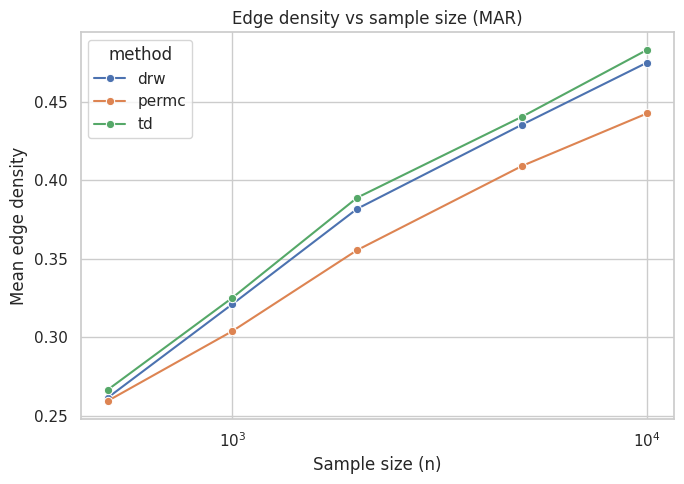

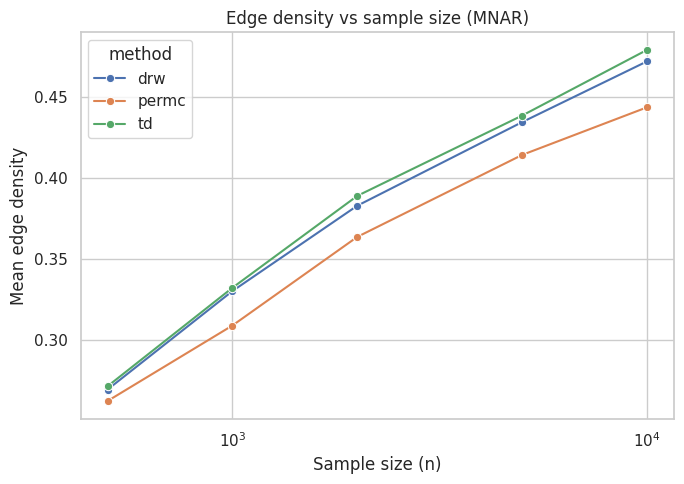

In [10]:
for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary_density[summary_density["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_density",
        hue="method",
        marker="o"
    )

    plt.title(f"Edge density vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean edge density")
    plt.xscale("log")
    plt.tight_layout()
    plt.show()


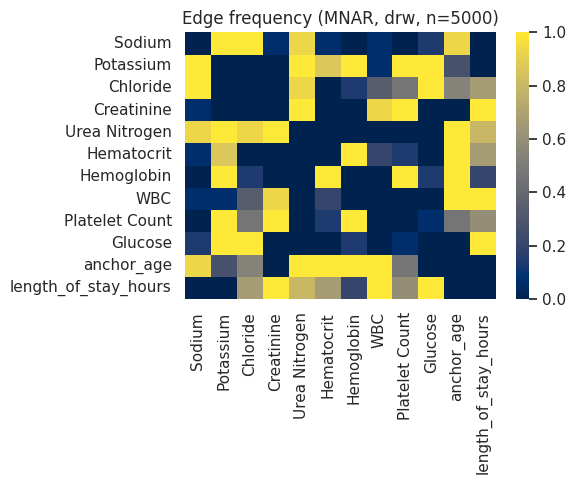

In [11]:
def edge_frequency_matrix(skeleton_list):
    k = skeleton_list[0].shape[0]
    F = np.zeros((k, k))
    R = len(skeleton_list)
    for S in skeleton_list:
        F += S
    F /= R
    return F

# Example: pick one setting
mode = "MNAR"
method = "drw"
n = 5000

F = edge_frequency_matrix(all_skeletons[(mode, method, n)])

plt.figure(figsize=(6, 5))
sns.heatmap(F, xticklabels=mvpc_vars, yticklabels=mvpc_vars, cmap="cividis", vmin=0, vmax=1)
plt.title(f"Edge frequency ({mode}, {method}, n={n})")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
target = "length_of_stay_hours"
j = idx[target]

def edge_freq_for_node(F, j, vars_list, threshold=0.5):
    res = []
    for i, v in enumerate(vars_list):
        if i == j:
            continue
        freq = F[i, j]
        res.append((v, freq))
    res.sort(key=lambda x: -x[1])
    return [r for r in res if r[1] >= threshold]

for mode in ["MAR", "MNAR"]:
    for method in methods:
        for n in [500, 5000]:
            F = edge_frequency_matrix(all_skeletons[(mode, method, n)])
            neigh = edge_freq_for_node(F, j, mvpc_vars, threshold=0.4)
            print(f"{mode}, {method}, n={n}:")
            for v, f in neigh:
                print(f"  {v}: {f:.2f}")
            print()


MAR, td, n=500:
  Creatinine: 1.00
  WBC: 1.00
  Urea Nitrogen: 0.80
  Glucose: 0.73

MAR, td, n=5000:
  Creatinine: 1.00
  WBC: 1.00
  Glucose: 1.00
  Urea Nitrogen: 0.87
  Hematocrit: 0.73
  Chloride: 0.67
  Platelet Count: 0.67

MAR, permc, n=500:
  Creatinine: 1.00
  WBC: 1.00
  Urea Nitrogen: 0.80
  Glucose: 0.73

MAR, permc, n=5000:
  Creatinine: 1.00
  WBC: 1.00
  Glucose: 0.93
  Urea Nitrogen: 0.87
  Hematocrit: 0.73
  Chloride: 0.67
  Platelet Count: 0.47

MAR, drw, n=500:
  Creatinine: 1.00
  WBC: 1.00
  Urea Nitrogen: 0.80
  Glucose: 0.73

MAR, drw, n=5000:
  Creatinine: 1.00
  WBC: 1.00
  Glucose: 1.00
  Urea Nitrogen: 0.87
  Hematocrit: 0.73
  Platelet Count: 0.67
  Chloride: 0.60

MNAR, td, n=500:
  Creatinine: 1.00
  WBC: 1.00
  Urea Nitrogen: 0.80
  Glucose: 0.53

MNAR, td, n=5000:
  Creatinine: 1.00
  WBC: 1.00
  Glucose: 1.00
  Urea Nitrogen: 0.87
  Chloride: 0.67
  Hematocrit: 0.67
  Platelet Count: 0.60

MNAR, permc, n=500:
  Creatinine: 1.00
  WBC: 1.00
  Urea Nitr

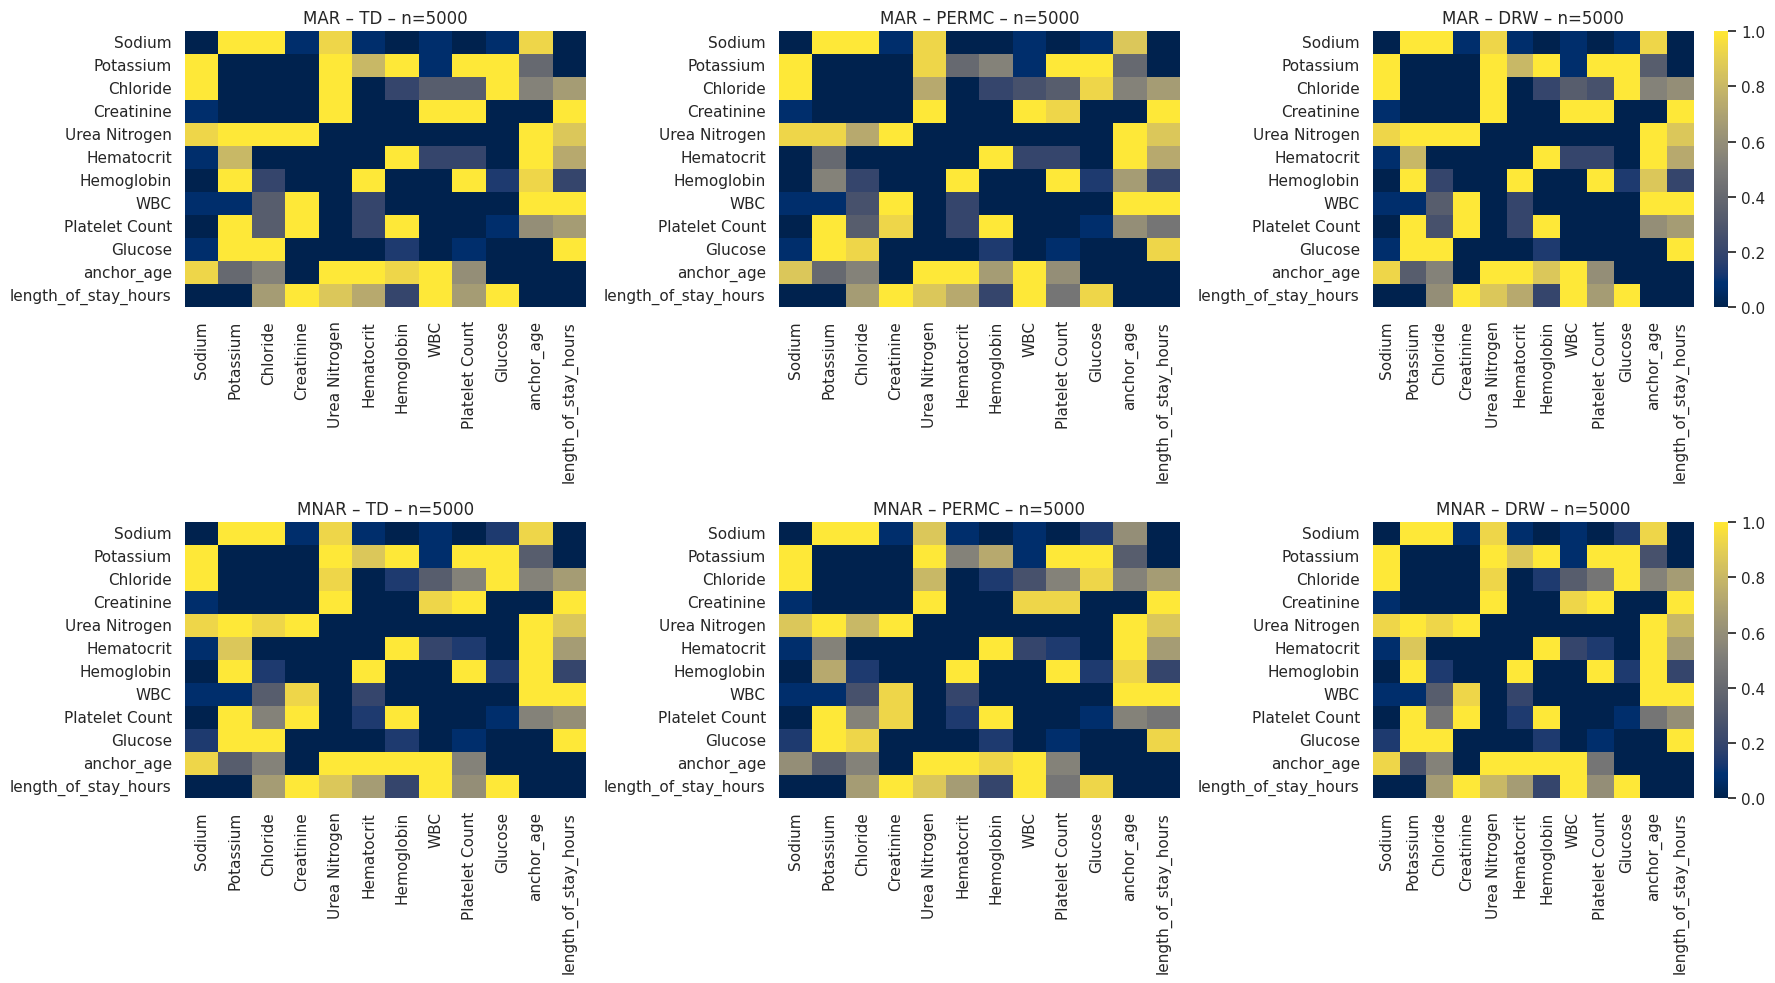

In [13]:
methods = ["td", "permc", "drw"]
modes = ["MAR", "MNAR"]
n = 5000   # or any sample size you want to visualize

fig, axes = plt.subplots(len(modes), len(methods), figsize=(18, 10))

for i, mode in enumerate(modes):
    for j, method in enumerate(methods):

        # Compute edge frequency matrix
        F = edge_frequency_matrix(all_skeletons[(mode, method, n)])

        ax = axes[i, j]
        sns.heatmap(
            F,
            ax=ax,
            xticklabels=mvpc_vars,
            yticklabels=mvpc_vars,
            cmap="cividis",
            vmin=0,
            vmax=1,
            cbar=(j == len(methods)-1)  # show colorbar only on last column
        )

        ax.set_title(f"{mode} – {method.upper()} – n={n}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


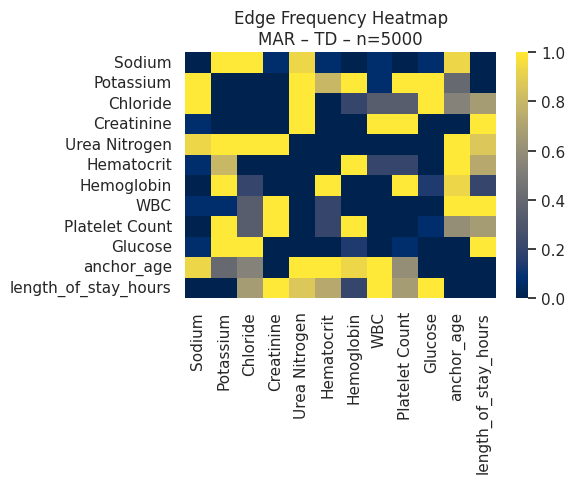

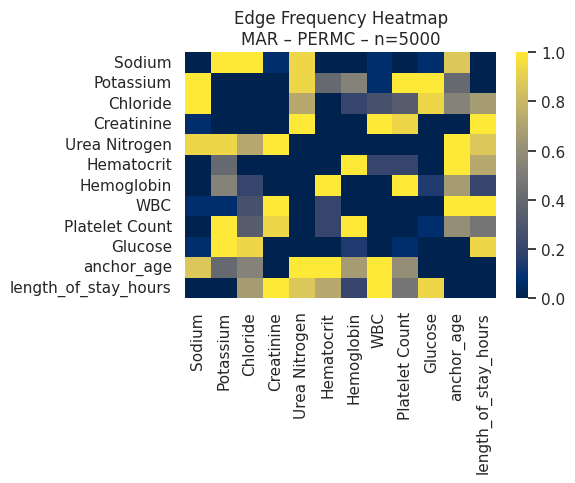

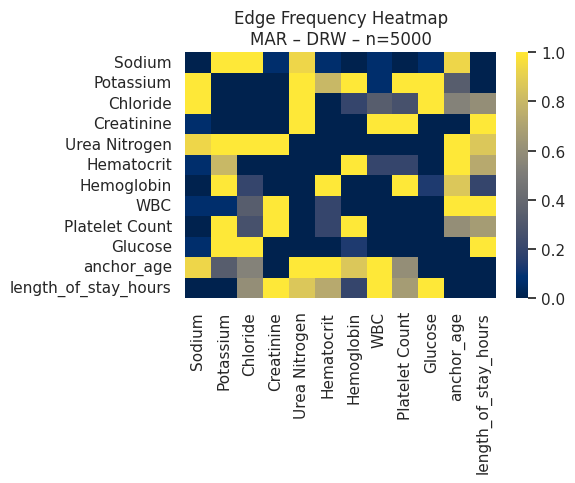

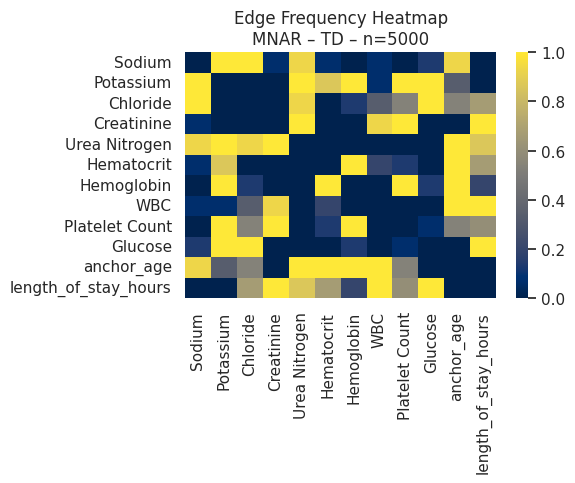

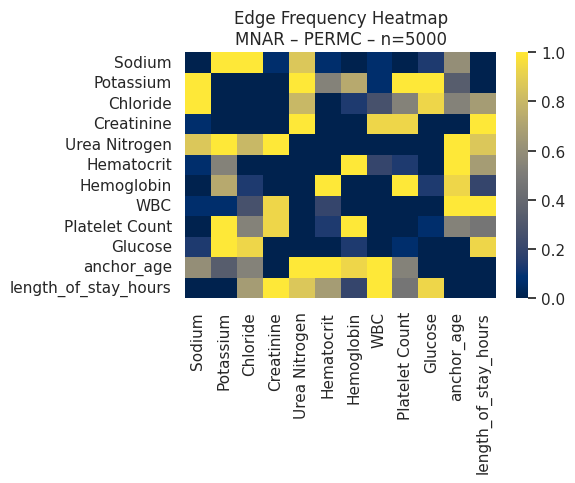

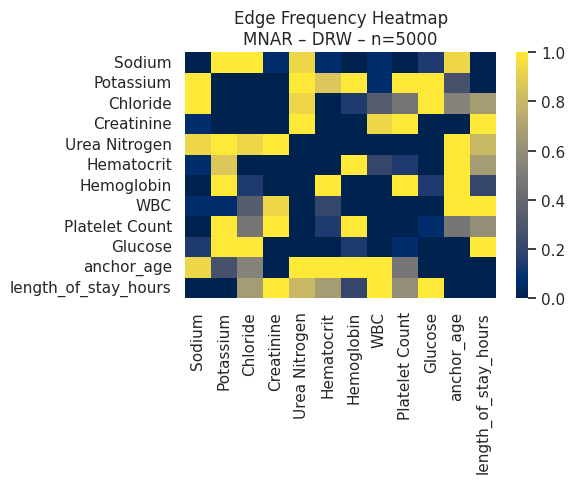

In [14]:
methods = ["td", "permc", "drw"]
modes = ["MAR", "MNAR"]
n = 5000   # choose the sample size you want to visualize

for mode in modes:
    for method in methods:

        # Compute edge frequency matrix
        F = edge_frequency_matrix(all_skeletons[(mode, method, n)])

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            F,
            xticklabels=mvpc_vars,
            yticklabels=mvpc_vars,
            cmap="cividis",
            vmin=0,
            vmax=1,
            cbar=True
        )

        plt.title(f"Edge Frequency Heatmap\n{mode} – {method.upper()} – n={n}")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


In [15]:
for mode in modes:
    for method in methods:
        F = edge_frequency_matrix(all_skeletons[(mode, method, n)])
        print(f"\n=== {mode} – {method.upper()} – n={n} ===")
        display(pd.DataFrame(F, index=mvpc_vars, columns=mvpc_vars).round(2))



=== MAR – TD – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.93,0.07,0.00,0.07,0.00,0.07,0.93,0.00
Potassium,1.00,0.00,0.00,0.00,1.00,0.80,1.00,0.07,1.00,1.00,0.40,0.00
Chloride,1.00,0.00,0.00,0.00,1.00,0.00,0.20,0.33,0.33,1.00,0.53,0.67
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00
Urea Nitrogen,0.93,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87
Hematocrit,0.07,0.80,0.00,0.00,0.00,0.00,1.00,0.20,0.20,0.00,1.00,0.73
Hemoglobin,0.00,1.00,0.20,0.00,0.00,1.00,0.00,0.00,1.00,0.13,0.93,0.20
WBC,0.07,0.07,0.33,1.00,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.33,1.00,0.00,0.20,1.00,0.00,0.00,0.07,0.60,0.67
Glucose,0.07,1.00,1.00,0.00,0.00,0.00,0.13,0.00,0.07,0.00,0.00,1.00



=== MAR – PERMC – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.93,0.00,0.00,0.07,0.00,0.07,0.87,0.00
Potassium,1.00,0.00,0.00,0.00,0.93,0.40,0.53,0.07,1.00,1.00,0.40,0.00
Chloride,1.00,0.00,0.00,0.00,0.73,0.00,0.20,0.27,0.33,0.93,0.53,0.67
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.93,0.00,0.00,1.00
Urea Nitrogen,0.93,0.93,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87
Hematocrit,0.00,0.40,0.00,0.00,0.00,0.00,1.00,0.20,0.20,0.00,1.00,0.73
Hemoglobin,0.00,0.53,0.20,0.00,0.00,1.00,0.00,0.00,1.00,0.13,0.67,0.20
WBC,0.07,0.07,0.27,1.00,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.33,0.93,0.00,0.20,1.00,0.00,0.00,0.07,0.60,0.47
Glucose,0.07,1.00,0.93,0.00,0.00,0.00,0.13,0.00,0.07,0.00,0.00,0.93



=== MAR – DRW – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.93,0.07,0.00,0.07,0.00,0.07,0.93,0.00
Potassium,1.00,0.00,0.00,0.00,1.00,0.80,1.00,0.07,1.00,1.00,0.33,0.00
Chloride,1.00,0.00,0.00,0.00,1.00,0.00,0.20,0.33,0.27,1.00,0.53,0.60
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00
Urea Nitrogen,0.93,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87
Hematocrit,0.07,0.80,0.00,0.00,0.00,0.00,1.00,0.20,0.20,0.00,1.00,0.73
Hemoglobin,0.00,1.00,0.20,0.00,0.00,1.00,0.00,0.00,1.00,0.13,0.87,0.20
WBC,0.07,0.07,0.33,1.00,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.27,1.00,0.00,0.20,1.00,0.00,0.00,0.00,0.60,0.67
Glucose,0.07,1.00,1.00,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.00,1.00



=== MNAR – TD – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.93,0.07,0.00,0.07,0.00,0.13,0.93,0.00
Potassium,1.00,0.00,0.00,0.00,1.00,0.87,1.00,0.07,1.00,1.00,0.33,0.00
Chloride,1.00,0.00,0.00,0.00,0.93,0.00,0.13,0.33,0.53,1.00,0.53,0.67
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,0.93,1.00,0.00,0.00,1.00
Urea Nitrogen,0.93,1.00,0.93,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87
Hematocrit,0.07,0.87,0.00,0.00,0.00,0.00,1.00,0.20,0.13,0.00,1.00,0.67
Hemoglobin,0.00,1.00,0.13,0.00,0.00,1.00,0.00,0.00,1.00,0.13,1.00,0.20
WBC,0.07,0.07,0.33,0.93,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.53,1.00,0.00,0.13,1.00,0.00,0.00,0.07,0.53,0.60
Glucose,0.13,1.00,1.00,0.00,0.00,0.00,0.13,0.00,0.07,0.00,0.00,1.00



=== MNAR – PERMC – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.87,0.07,0.00,0.07,0.00,0.13,0.60,0.00
Potassium,1.00,0.00,0.00,0.00,1.00,0.53,0.73,0.07,1.00,1.00,0.33,0.00
Chloride,1.00,0.00,0.00,0.00,0.80,0.00,0.13,0.27,0.53,0.93,0.53,0.67
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,0.93,0.93,0.00,0.00,1.00
Urea Nitrogen,0.87,1.00,0.80,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87
Hematocrit,0.07,0.53,0.00,0.00,0.00,0.00,1.00,0.20,0.13,0.00,1.00,0.67
Hemoglobin,0.00,0.73,0.13,0.00,0.00,1.00,0.00,0.00,1.00,0.13,0.93,0.20
WBC,0.07,0.07,0.27,0.93,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.53,0.93,0.00,0.13,1.00,0.00,0.00,0.07,0.53,0.47
Glucose,0.13,1.00,0.93,0.00,0.00,0.00,0.13,0.00,0.07,0.00,0.00,0.93



=== MNAR – DRW – n=5000 ===


,Sodium,Potassium,Chloride,Creatinine,Urea Nitrogen,Hematocrit,Hemoglobin,WBC,Platelet Count,Glucose,anchor_age,length_of_stay_hours
Sodium,0.00,1.00,1.00,0.07,0.93,0.07,0.00,0.07,0.00,0.13,0.93,0.00
Potassium,1.00,0.00,0.00,0.00,1.00,0.87,1.00,0.07,1.00,1.00,0.27,0.00
Chloride,1.00,0.00,0.00,0.00,0.93,0.00,0.13,0.33,0.47,1.00,0.53,0.67
Creatinine,0.07,0.00,0.00,0.00,1.00,0.00,0.00,0.93,1.00,0.00,0.00,1.00
Urea Nitrogen,0.93,1.00,0.93,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.80
Hematocrit,0.07,0.87,0.00,0.00,0.00,0.00,1.00,0.20,0.13,0.00,1.00,0.67
Hemoglobin,0.00,1.00,0.13,0.00,0.00,1.00,0.00,0.00,1.00,0.13,1.00,0.20
WBC,0.07,0.07,0.33,0.93,0.00,0.20,0.00,0.00,0.00,0.00,1.00,1.00
Platelet Count,0.00,1.00,0.47,1.00,0.00,0.13,1.00,0.00,0.00,0.07,0.47,0.60
Glucose,0.13,1.00,1.00,0.00,0.00,0.00,0.13,0.00,0.07,0.00,0.00,1.00
